In [1]:
import numpy as np
import pandas as pd
from datetime import date, datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
historic_data = pd.read_csv('historic_data.csv')
oot = pd.read_csv('forecasting.csv') 

In [3]:
target_columns = ['Unidades','Items','Volumen_promo','Volumen_NOpromo','Valor','Valor_promo','Valor_NOpromo','Universo']
# keep volumen
other  =['Fecha','Mercado']
cols_to_drop= target_columns + other

#historic_data = historic_data[columns=['Fecha', 'Mercado'], axis=1]

In [4]:
keep_col = [col for col in historic_data.columns if col not in cols_to_drop]
historic_data_2 = historic_data[keep_col]

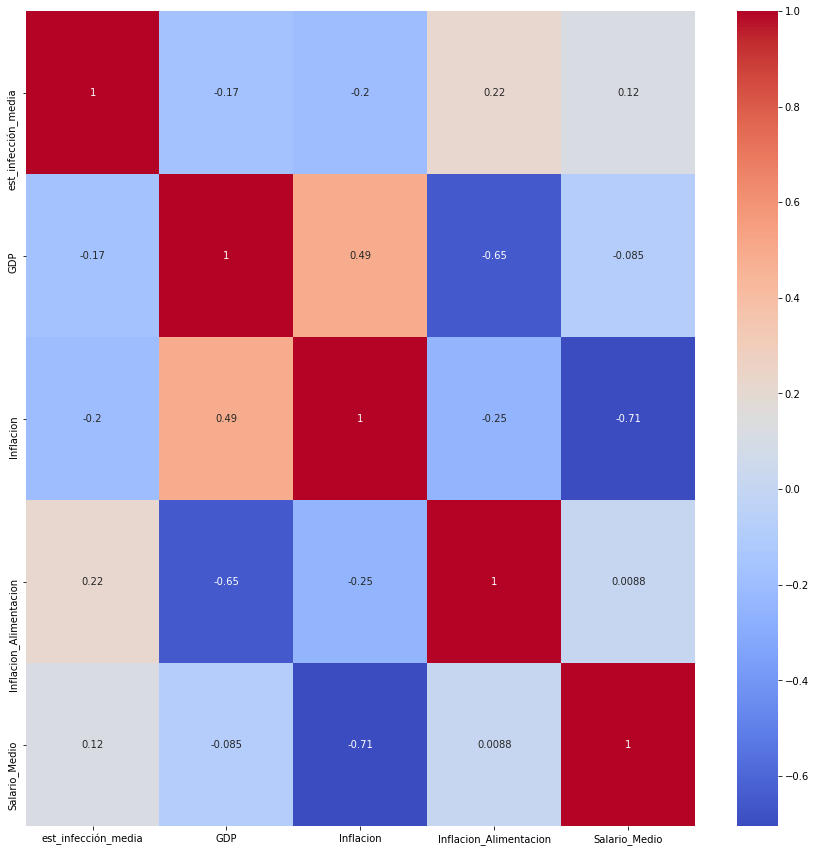

In [5]:
numerical_columns = ['est_infección_media','GDP','Inflacion','Inflacion_Alimentacion','Salario_Medio']
correlation_test = historic_data_2[numerical_columns]
# for numerical columns (excluding target columns)
corrMatrix = correlation_test.corr()
plt.figure(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True, cmap='coolwarm')

In [6]:
# bind the 2 datasets
dataset = historic_data_2.append(oot)

In [7]:
dataset

,id_Mercado,id_Producto,Sector,Seccion,Categoria,Escenario,est_infección_media,est_infección_inf,est_infección_sup,GDP,Inflacion,Inflacion_Alimentacion,Salario_Medio,Año,Mes,Trimestre,Semana,Volumen
0,MU6XW,L4O8DDGT,ALIM. Y BEBIDAS,ALIM.SECA,ACEITE,pre_confinement,0.0,0.0,0.0,283402.9,0.019,0.011,2395.0,2017,5.0,2,21.0,165736.0
1,MU6XZ,L4O8DDEU,PROD.FRESCOS,DERV.LACTEOS,MANTEQUILLA,pre_confinement,0.0,0.0,0.0,283402.9,0.019,0.011,2395.0,2017,5.0,2,21.0,3725.0
2,MU6XT,L4O8DDC4,ALIM. Y BEBIDAS,ALIM.SECA,CACAO,pre_confinement,0.0,0.0,0.0,283402.9,0.019,0.011,2395.0,2017,5.0,2,21.0,3984.0
3,MU6XZ,L4O8DDES,PROD.FRESCOS,DERV.LACTEOS,MARGARINA,pre_confinement,0.0,0.0,0.0,283402.9,0.019,0.011,2395.0,2017,5.0,2,21.0,5116.0
4,MU6XZ,L4O8DDCG,PROD.FRESCOS,DERV.LACTEOS,NATA,pre_confinement,0.0,0.0,0.0,283402.9,0.019,0.011,2395.0,2017,5.0,2,21.0,9611.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23935,MU6XQ,L4O8DDCM,PROD.FRESCOS,QUESOS,QUESO RALLADO,post_confinement,323.0,113.0,1163.0,237327.0,-0.002,0.020,2720.0,2020,9.0,3,39.0,NaN
23936,MU6XQ,L4O8DDCA,PROD.FRESCOS,QUESOS,QUESO TRADICIONAL,post_confinement,323.0,113.0,1163.0,237327.0,-0.002,0.020,2720.0,2020,9.0,3,39.0,NaN
23937,MU6XQ,L4O8DDCO,PROD.FRESCOS,QUESOS,QUESOS BLANCOS PASTEURIZADOS,post_confinement,323.0,113.0,1163.0,237327.0,-0.002,0.020,2720.0,2020,9.0,3,39.0,NaN
23938,MU6XQ,L4O8DDCQ,PROD.FRESCOS,QUESOS,REQUESON,post_confinement,323.0,113.0,1163.0,237327.0,-0.002,0.020,2720.0,2020,9.0,3,39.0,NaN


In [8]:
dataset_light = dataset.drop(columns=['Seccion', 'Categoria', 'est_infección_inf','est_infección_sup'], axis=1) 

In [9]:
dataset_heavy = dataset.drop(columns=['Seccion', 'Categoria'], axis=1)

In [10]:
categorical_columns = ['id_Mercado','id_Producto','Sector', 'Escenario','Año','Mes','Trimestre','Semana']
numerical_columns = ['est_infección_media','GDP','Inflacion','Inflacion_Alimentacion','Salario_Medio']
#target_columns = ['Unidades','Items','Volumen','Volumen_promo','Volumen_NOpromo','Valor','Valor_promo','Valor_NOpromo','Universo']

dataset_light[categorical_columns] = dataset_light[categorical_columns].astype("category")


## transformations on oot at the same time and then ssplit again into historic_train and predict_df

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_cols = dataset_light.columns[dataset_light.dtypes=='category'].tolist()
#categorical_cols.remove('Mercado') # Remove mercado since we have the mercado id

# numerical columns: amend the variable to remove  the columns that are highly correlated
numerical_cols = numerical_columns

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

# Concat the numerical and dummified categorical columns & the target columns
dummified_all = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(dataset_light[numerical_cols])), 
                                                  columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(dataset_light[categorical_cols]).toarray(), 
                                            columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
                                    dataset_light['Volumen'].reset_index(drop=True)], axis=1)

dummified_all_map = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(dataset_light[numerical_cols])), 
                                                  columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(dataset_light[categorical_cols]).toarray(), 
                                            columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
                                    dataset_light[categorical_columns].reset_index(drop=True)],axis=1)


In [12]:
# re-split into historic_df and predict_df
historic_df = dummified_all.iloc[0:273600]
predict_df = dummified_all.iloc[273600:]
predict_df = predict_df.drop(['Volumen'], axis=1)

historic_map = dummified_all_map.iloc[0:273600]
predict_map = dummified_all_map.iloc[273600:]

In [13]:
# split into train-test 

from sklearn.model_selection import train_test_split

X = historic_df.drop(['Volumen'], axis=1) # here: cols not '_columns' cause i modified to contain specific cols
y = historic_df['Volumen']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
clf = RandomForestRegressor(max_features='sqrt', n_estimators=40, random_state = 42)
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [15]:
y_pred = clf.predict(X_test)

error = y_pred - y_test
mean_absolute_error(y_test, y_pred), r2_score(y_test,y_pred), clf.score(X_test, y_test)

(4317.573501701961, 0.9646887499318485, 0.9646887499318485)

In [16]:
# Perform K-Fold CV
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='r2')

In [17]:
scores

array([0.97373053, 0.97126656, 0.96051093, 0.96664201, 0.96969735,
       0.96999787, 0.96615364, 0.97164105, 0.96929871, 0.97233096])

In [18]:
final_pred = clf.predict(predict_df)

In [19]:
predict_df['Volumen'] = final_pred

In [21]:
cols_pred = list(predict_df.columns)
cols_map = list(predict_map.columns)
cols_pred.remove('Volumen')

cols_map.remove('id_Mercado')
cols_map.remove('id_Producto')
cols_map.remove('Sector')
cols_map.remove('Escenario')
cols_map.remove('Año')
cols_map.remove('Mes')
cols_map.remove('Trimestre')
cols_map.remove('Semana')

In [ ]:
#predict_map = predict_map.drop('Volumen', axis=1)

In [22]:
Predict_final = predict_map.merge(predict_df, how='left', 
                   left_on= cols_map, 
                   right_on= cols_pred)

In [23]:
Predict_final_1 = Predict_final.copy()
#Predict_final = Predict_final_1.copy()

In [24]:
Predict_final

,est_infección_media,GDP,Inflacion,Inflacion_Alimentacion,Salario_Medio,id_Mercado_MU6XK,id_Mercado_MU6XL,id_Mercado_MU6XM,id_Mercado_MU6XN,id_Mercado_MU6XO,...,Semana_52.0,id_Mercado,id_Producto,Sector,Escenario,Año,Mes,Trimestre,Semana,Volumen
0,0.009991,0.0,0.18750,0.5,0.925373,0.0,0.0,0.0,0.0,0.0,...,0.0,MU6XW,L4O8DDGT,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26.0,168376.500
1,0.009991,0.0,0.18750,0.5,0.925373,0.0,0.0,0.0,0.0,0.0,...,0.0,MU6XW,L4O8DDGJ,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26.0,121637.800
2,0.009991,0.0,0.18750,0.5,0.925373,0.0,0.0,0.0,0.0,0.0,...,0.0,MU6XW,L4O8DDG2,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26.0,33212.125
3,0.009991,0.0,0.18750,0.5,0.925373,0.0,0.0,0.0,0.0,0.0,...,0.0,MU6XW,L4O8DDG4,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26.0,174298.475
4,0.009991,0.0,0.18750,0.5,0.925373,0.0,0.0,0.0,0.0,0.0,...,0.0,MU6XW,L4O8DDG9,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26.0,45363.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23935,0.001917,0.0,0.21875,0.5,0.925373,0.0,0.0,0.0,0.0,0.0,...,0.0,MU6XQ,L4O8DDCM,PROD.FRESCOS,post_confinement,2020,9.0,3,39.0,3503.550
23936,0.001917,0.0,0.21875,0.5,0.925373,0.0,0.0,0.0,0.0,0.0,...,0.0,MU6XQ,L4O8DDCA,PROD.FRESCOS,post_confinement,2020,9.0,3,39.0,6755.100
23937,0.001917,0.0,0.21875,0.5,0.925373,0.0,0.0,0.0,0.0,0.0,...,0.0,MU6XQ,L4O8DDCO,PROD.FRESCOS,post_confinement,2020,9.0,3,39.0,1875.525
23938,0.001917,0.0,0.21875,0.5,0.925373,0.0,0.0,0.0,0.0,0.0,...,0.0,MU6XQ,L4O8DDCQ,PROD.FRESCOS,post_confinement,2020,9.0,3,39.0,483.375


In [25]:
Predict_final = Predict_final.drop(cols_map, axis=1)
historic_final = historic_map.drop(cols_map, axis=1)

Predict_final['Año'] = Predict_final['Año'].astype(int)
Predict_final['Semana'] = Predict_final['Semana'].astype(int)

historic_final['Año'] = historic_final['Año'].astype(int)
historic_final['Semana'] = historic_final['Semana'].astype(int)

In [26]:
Predict_final['formatted_date'] = Predict_final.Año * 1000 + Predict_final.Semana * 10 + 0
Predict_final['Fecha'] = pd.to_datetime(Predict_final['formatted_date'], format='%Y%W%w')

historic_final['formatted_date'] = historic_final.Año * 1000 + historic_final.Semana * 10 + 0
historic_final['Fecha'] = pd.to_datetime(historic_final['formatted_date'], format='%Y%W%w')
historic_final

Predict_final = Predict_final.drop('formatted_date', axis=1)
historic_final = historic_final.drop('formatted_date', axis=1)

In [27]:
Predict_final

,id_Mercado,id_Producto,Sector,Escenario,Año,Mes,Trimestre,Semana,Volumen,Fecha
0,MU6XW,L4O8DDGT,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26,168376.500,2020-07-05
1,MU6XW,L4O8DDGJ,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26,121637.800,2020-07-05
2,MU6XW,L4O8DDG2,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26,33212.125,2020-07-05
3,MU6XW,L4O8DDG4,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26,174298.475,2020-07-05
4,MU6XW,L4O8DDG9,ALIM. Y BEBIDAS,post_confinement,2020,6.0,2,26,45363.500,2020-07-05
...,...,...,...,...,...,...,...,...,...,...
23935,MU6XQ,L4O8DDCM,PROD.FRESCOS,post_confinement,2020,9.0,3,39,3503.550,2020-10-04
23936,MU6XQ,L4O8DDCA,PROD.FRESCOS,post_confinement,2020,9.0,3,39,6755.100,2020-10-04
23937,MU6XQ,L4O8DDCO,PROD.FRESCOS,post_confinement,2020,9.0,3,39,1875.525,2020-10-04
23938,MU6XQ,L4O8DDCQ,PROD.FRESCOS,post_confinement,2020,9.0,3,39,483.375,2020-10-04


In [ ]:
#predictions = pd.DataFrame({'id_Mercado':predict_df['id_Mercado'], 'id_Producto':predict_df['id_Producto'], 'volumen':final_pred})
#predictions.to_csv("predictionsFinal.csv", index=False)

In [28]:
FINAL = historic_final.append(Predict_final)

In [ ]:
#FINAL.to_csv("predictionsFinalTABLEAU.csv", index=False)

In [ ]:
#plt.plot(a)